In [1]:
import random
import matplotlib.pyplot as plt
import math
import sys
import warnings
import numpy as np
from ipywidgets import interact

Уравнение:
$$\frac{\partial^2u}{\partial t^2} + 3 \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial u}{\partial x} - u + sin(x) e^{-t}$$

Граничные условия
$$
u(0,t) = e^{-t} \\
u(\pi, t) = -e^{-t}
$$

Начальные условия
$$
u(x,0) = cos(x)\\
u_t(x,0) = -cos(x)
$$

Аналитическое решение
$$
U(x,t) = e^{-t}cos(x)
$$

In [2]:
def psi_1(x):
  return np.cos(x)

def psi_2(x):
  return -np.cos(x)

def dpsi2_dx2(x):
  return np.cos(x)

def phi_0(t):
  return np.exp(-t)

def phi_l(t):
  return -np.exp(-t)

def U(x,t):
  return np.exp(-t) * np.cos(x)


In [3]:
class Schema:
    def __init__(self, psi1=psi_1, psi2=psi_2,
                 diffpsi2=dpsi2_dx2, f0=phi_0, fl=phi_l, 
                 l0=0, l1=math.pi, T=5, order2nd=True):
        self.psi1 = psi1
        self.diffpsi = diffpsi2
        self.psi2 = psi2
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None
        self.h = None
        self.order = order2nd
        self.sigma = None
        self.f0 = f0
        self.fl = fl
 
    def CalculateH(self, N):
        self.h = (self.l1 - self.l0) / N
        
    def CalculateTau(self, K):
        self.tau = self.T / K
        
    def CalculateSigma(self):
        self.sigma = self.tau*self.tau / (self.h*self.h)
        
    def Set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1
        
    def SetT(self, T):
        self.T = T
      
    @staticmethod
    def nparange(start, end, step = 1):
        curr = start
        e = 0.00000000001
        while curr - e <= end:
            yield curr
            curr += step
        
    def CalculateLine(self, t, x, lastLine1, lastLine2):
        pass
    
    def __call__(self, N=50, K=100):
        N, K = N - 1, K - 1
        self.CalculateTau(K)
        self.CalculateH(N)
        self.CalculateSigma()
        ans = []
        x = list(self.nparange(self.l0, self.l1, self.h))
        lastLine = list(map(self.psi1, x))
        ans.append(list(lastLine))
        if self.order:
            lastLine = list(map(lambda a: self.psi1(a) + self.tau * self.psi2(a) + self.tau * self.tau * self.diffpsi(a) / 2, x))
        else:
            lastLine = list(map(lambda a: self.psi1(a) + self.tau * self.psi2(a), x))
        ans.append(list(lastLine))
        Y = [0]
        Y.append(self.tau)
        for t in self.nparange(self.tau + self.tau, self.T, self.tau):
            ans.append(self.CalculateLine(t, x, ans[-1], ans[-2]))
            Y.append(t)
        return x, Y, ans

### Явная схема

In [4]:
class ExplictSchema(Schema):
    def CalculateSigma(self):
        self.sigma =  self.tau * self.tau / (self.h * self.h)
        if self.sigma > 1:
            warnings.warn("Sigma > 1")
        
    def CalculateLine(self, t, x, lastLine1, lastLine2):
        line = [None for _ in lastLine1]
        for i in range(1, len(x) - 1):
            
            line[i] = self.sigma * (lastLine1[i - 1] - 2 * lastLine1[i] + lastLine1[i + 1])
            line[i] += self.sigma * self.h * (lastLine1[i + 1] - lastLine1[i - 1])
            line[i] += lastLine1[i] * (2. - self.tau * self.tau)
            line[i] -= lastLine2[i] * (1. - 3. * self.tau)
            line[i] += self.tau * self.tau * np.sin(x[i]) * np.exp(-t)
            line[i] /= (1. + 3. * self.tau)

        line[0] = self.f0(t)
        line[-1] = self.fl(t)
        return line

### Неявная схема

In [5]:
class ImplicitSchema(Schema):
    @staticmethod
    def SweepMethod(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
        x = [item for item in Q]
        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]
        return x
    
    def CalculateLine(self, t, x, lastLine1, lastLine2):
        a = -self.sigma + self.sigma * self.h
        b = 1 + 3. * self.tau + 2. * self.sigma + self.tau * self.tau
        c = -self.sigma - self.sigma * self.h
        A = [(a, b, c) for _ in range(1, len(x) - 1)]
        w = [self.tau * self.tau * np.sin(x[i]) * np.exp(-t) + 2. * lastLine1[i] + (3 * self.tau - 1.) * lastLine2[i] for i in range(1, len(x) - 1)]
        koeffs = (0, b, c, (self.tau * self.tau * np.sin(x[0]) * np.exp(-t) + 2. * lastLine1[0] + (3 * self.tau - 1.) * lastLine2[0]) - a * self.f0(t))
        #koeffs = (0, b, c, (((1 - self.tau) * lastLine2[1] - 2 * lastLine1[1]) / self.sigma) - a * self.f0(t))
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        koeffs = (a, b, 0, (self.tau * self.tau * np.sin(x[-1]) * np.exp(-t) + 2. * lastLine1[-1] + (3 * self.tau - 1.) * lastLine2[-1]) - c * self.fl(t))
        #koeffs = (a, b, 0, (((1 - self.tau) * lastLine2[-2] - 2 * lastLine1[-2]) / self.sigma) - c * self.fl(t))
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        ans = self.SweepMethod(A, w)
        return ans

### Результаты

In [6]:
def eps(X, Y, Z, U):
    err = .0
    for i in range(len(Y)):
        for j in range(len(X)):
            err += (Z[i][j] - U(X[j], Y[i])) ** 2
        err /= len(X)
    return (err) ** 0.5   

In [7]:
def Error(X, Y, Z, U):
    ans = 0.0
    for i in range(len(Y)):
        for j in range(len(X)):
            tmp = abs(Z[i][j] -  U(X[j], Y[i]))
            ans = tmp if tmp > ans else ans
    return ans

In [8]:
def GetStepHandEror(solver, real_f):
    h = []
    e = []
    for N in range(5, 30, 2):
        x, y, z = solver(N, 100)
        h.append(solver.h)
        e.append(Error(x, y, z, real_f))
    return h, e

In [9]:
def error_on_h( method, U, h_0, h_l , T,  name=None):
    steps = []
    e = []
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for N in range(h_0, h_l):
        x, y, z = method(N, T)
        steps.append(N)
        err = Error(x, y, z, U)
        e.append(err)
    ax.plot(steps, e, c='red')
    info = name + "\nЗависимость ошибки от мелкости разбиения по h"
    ax.set_title(info)
    ax.set_xlabel("Число разбиений")
    ax.set_ylabel("Ошибка")


In [10]:
def error_on_t( method, U, t_0, t_l, H, name=None):
    steps = []
    e = []
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for N in range(t_0, t_l):
        x, y, z = method(H, N * N)
        steps.append(N * N)
        err = Error(x, y, z, U)
        e.append(err)
    ax.plot(steps, e, c='red')
    info = name + "\nЗависимость ошибки от мелкости разбиения по t"
    ax.set_title(info)
    ax.set_xlabel("Число разбиений")
    ax.set_ylabel("Ошибка")

In [11]:
def depend_on_h(X, Y, Z, name=None, method=None):
    t = np.linspace(0, len(Y), num=5, endpoint=False, dtype=int)
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for i in t:
        ax.plot(X, Z[i])
    legends = ["t=" + str(round(k * method.tau, 3)) for k in t]
    ax.legend(legends)
    info = name + "\nh = " + str(round(method.h, 3)) + ", tau = " + str(round(method.tau, 3)) + ", sigma = " + str(round(method.sigma, 3))
    ax.set_title(info)
    ax.set_xlabel("x")
    ax.set_ylabel("U(x,t)")

In [12]:
explicit = ExplictSchema(T=1)
X1, Y1, Z1 = explicit(50, 100)

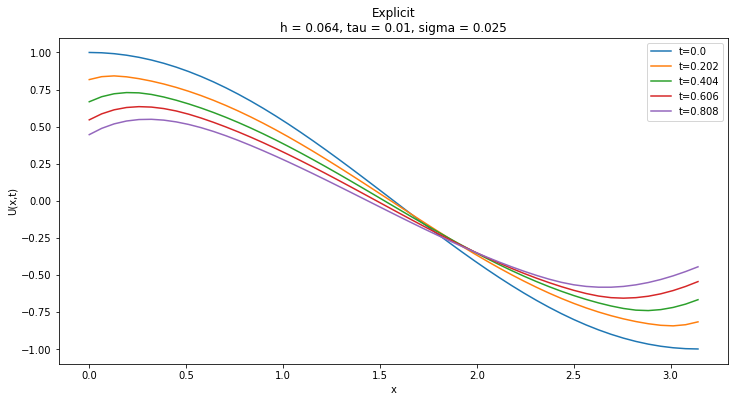

In [13]:
depend_on_h(X1, Y1, Z1, "Explicit", explicit)

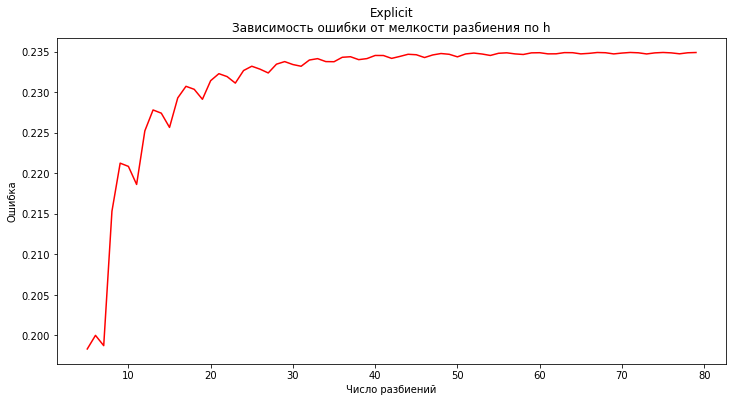

In [23]:
error_on_h(explicit, U, 5, 80, 100, "Explicit")

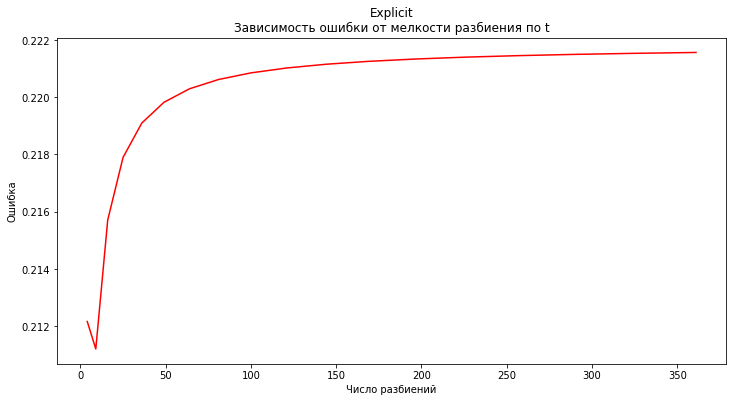

In [22]:
error_on_t(explicit, U, 2, 20, 10, "Explicit")

In [16]:
#k - количество разбиений
def plotDependenceT(n=5, k=10, t=1):
    schema = ExplictSchema(T=t)
    x, y, z = schema(N=n, K=k)
    plt.figure(figsize=(18, 20))
    for i in range(1, 6):
        plt.subplot(5, 1, i)
        j = (k * (i - 1)) // 5
        X = x
        Z = z[j]
        T = y[j]
        
        plt.plot(X, Z, label="time:" + str(T), color='#00FF00')
        plt.plot(X, list(map(lambda o: U(o, T), X)), label='real function', color='#FF00FF')
        plt.grid()
        plt.legend()

In [17]:
implicit = ImplicitSchema(T=1)
X2, Y2, Z2 = implicit(50, 100)

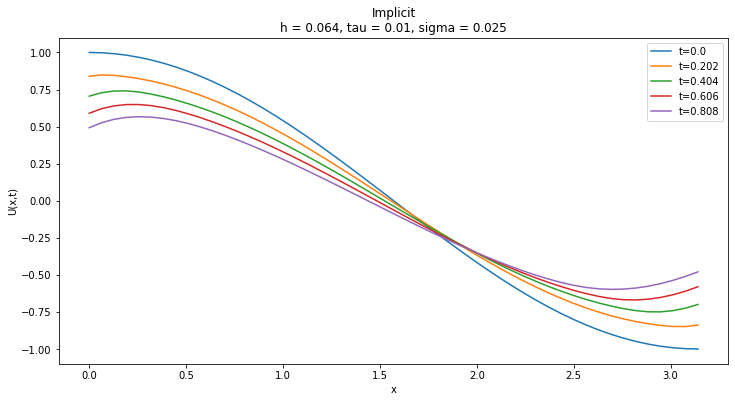

In [18]:
depend_on_h(X2, Y2, Z2, "Implicit", implicit)

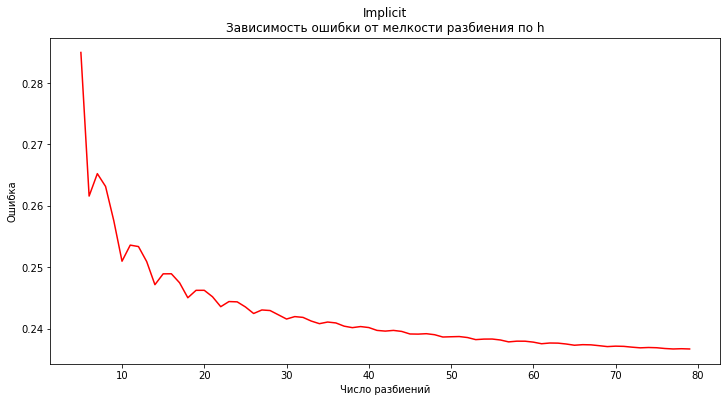

In [19]:
error_on_h(implicit, U, 5, 80, 100, "Implicit")

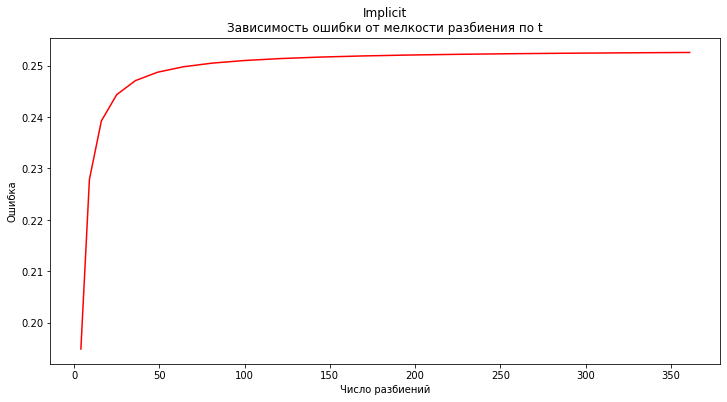

In [20]:
error_on_t(implicit, U, 2, 20, 10, "Implicit")